# Time Series Analysis and Univariate ARIMA Models

###  Data_reader
https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#fred

In [26]:
import os
import sys
import warnings
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError
warnings.filterwarnings('ignore')

https://www.statsmodels.org/stable/api.html

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html?highlight=tsaplots


https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [27]:
import statsmodels.tsa.api as tsa                                      #time_series_models
import statsmodels.api as sm                                           #cross_sectional_models

from statsmodels.graphics.tsaplots import plot_acf,acf,plot_pacf,pacf  #plots for autocorrelation and Partial autocorrelation function
from statsmodels.tsa.stattools import acf, q_stat, adfuller         
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Download Time Series data

#### What does squeeze function do ?
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.squeeze.html

In [28]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna() #industrial manufacturing production data
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [7]:
industrial_production.index = pd.to_datetime(industrial_production.index, format="%Y%m").to_period('M')

In [29]:
industrial_production

DATE
1988-01-01     56.7982
1988-02-01     58.0084
1988-03-01     58.6871
1988-04-01     58.9176
1988-05-01     59.0147
                ...   
2017-08-01    104.1295
2017-09-01    103.7343
2017-10-01    105.5815
2017-11-01    104.3294
2017-12-01    102.8589
Name: IPGMFN, Length: 360, dtype: float64

### How to decompose time series patterns 

 **Discussion points**

1. Time series data is mix of various patterns that can be decomposed into several components, each representing an underlying pattern category. 

2. Time series often consist of the systematic components : trend, seasonality and cycles, and unsystematic noise.

3. The above components can be combined in an additive, linear model (when fluctuations do not depend on the level of the series)

In [30]:
components=tsa.seasonal_decompose(industrial_production,model='additive')

In [31]:
components.seasonal

DATE
1988-01-01   -2.141664
1988-02-01   -0.595111
1988-03-01    0.781068
1988-04-01   -0.244667
1988-05-01    0.207465
                ...   
2017-08-01    0.927201
2017-09-01    1.539873
2017-10-01    1.479245
2017-11-01    0.088743
2017-12-01   -1.421056
Name: seasonal, Length: 360, dtype: float64

In [32]:
ts_components= (industrial_production.to_frame('Original_Series')
   .assign(Trend=components.trend)
   .assign(Seasonal=components.seasonal)
   .assign(Reisd=components.resid))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff74b87aa10>,
      dtype=object)

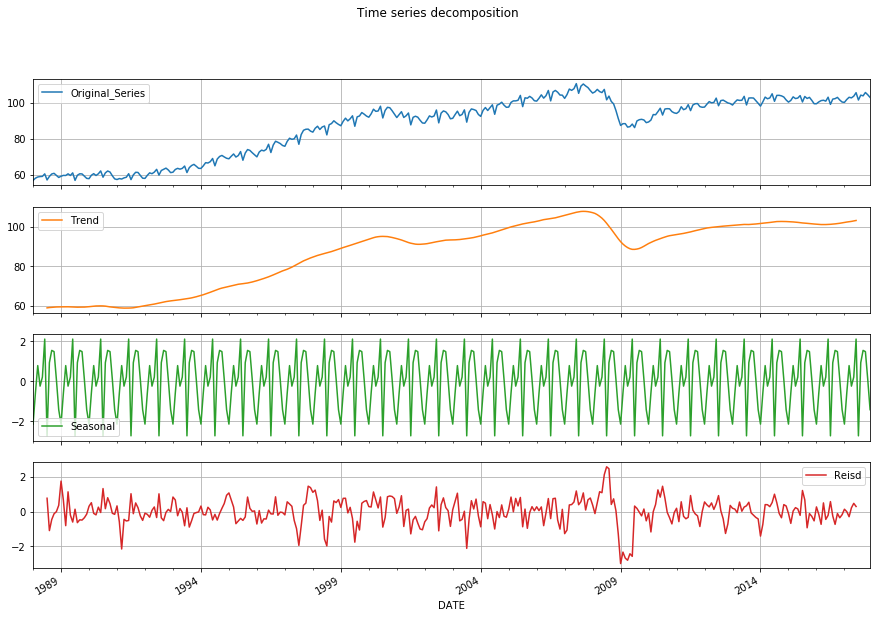

In [33]:
ts_components.plot(subplots=True,figsize=(15,10),grid=True,title="Time series decomposition")

The residual component would be the focus of additional modeling with the assumption trend and seasonality components 
are deterministic and easy to extrapolate 

### How to diagnose and achieve stationarity 

 **Discussion points**

1. The statistical properties (mean, variance, or autocorrelation) of a stationary time series are independent of the 
   period. 

2. What does it imply? Time series does not have a trend or seasonal effects, such that descriptive statistics for 
   different rolling windows are constant
   
3. The series reverts to mean and deviations have constant amplitude. 
4. Strict stationarity :  Joint distribution of any subset of time series observations to be independent of time with 
   respect to all moments. 
   
5. To satisfy the stationarity assumption of linear time series models, we need to transform the original time series.   


### Time Series Transformations 

In [34]:
print((nasdaq==0).any(),(industrial_production==0).any()) #check for zeroes


False False


In [35]:
log_nasdaq= np.log(nasdaq)
log_industrial_production=np.log(industrial_production)

#### Differencing 

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

In [36]:
log_nasdaq_diff=log_nasdaq.diff().dropna()
log_industrial_production_diff= log_industrial_production.diff(12).dropna() #yoy change 

## Augmented Dickey-Fuller test

 **Discussion points**

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

**Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1):**  The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.


**p-value > 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [37]:
result = adfuller(nasdaq.dropna())
print('ADF Statistic:%.2f' % result[0])
print('p-value: %.2f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic:0.88
p-value: 0.99
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Post transformation series_ Stacked SubPlots

https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html

https://matplotlib.org/1.4.0/users/transforms_tutorial.html


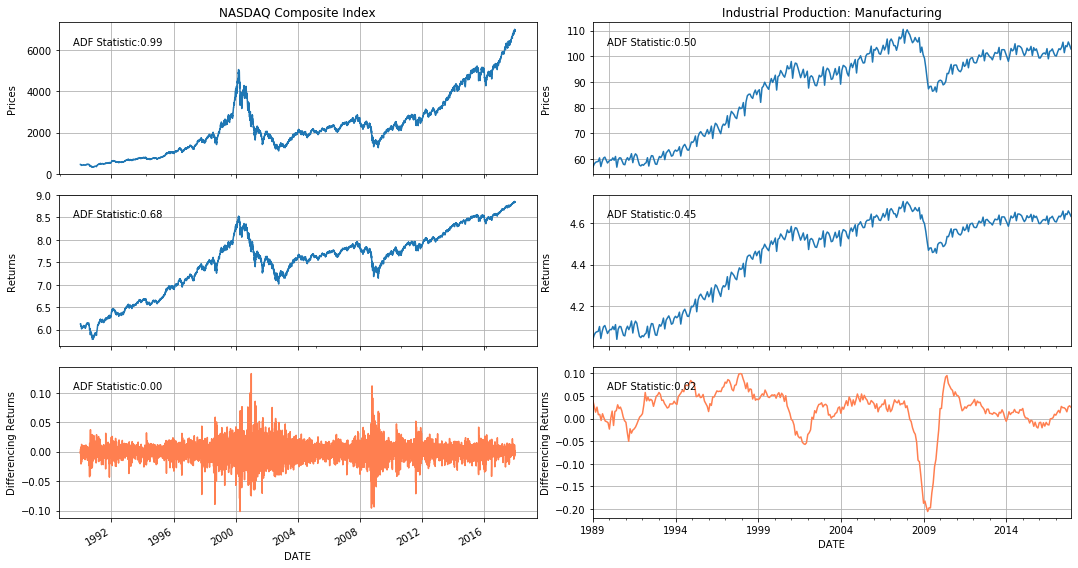

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))

#Nasdaq_Series

nasdaq.plot(ax=axes[0][0], title='NASDAQ Composite Index',grid=True)
axes[0][0].text(x=.03, y=.85,s='ADF Statistic:%.2f' % adfuller(nasdaq.dropna())[1], transform=axes[0][0].transAxes)
axes[0][0].set_ylabel('Prices')

log_nasdaq.plot(ax=axes[1][0], sharex=axes[0][0],grid=True)
axes[1][0].text(x=.03, y=.85,s='ADF Statistic:%.2f' % adfuller(log_nasdaq.dropna())[1], transform=axes[1][0].transAxes)
axes[1][0].set_ylabel('Returns')


log_nasdaq_diff.plot(ax=axes[2][0], sharex=axes[0][0],grid=True,color='coral')
axes[2][0].text(x=.03, y=.85,s='ADF Statistic:%.2f' % adfuller(log_nasdaq_diff.dropna())[1], transform=axes[2][0].transAxes)
axes[2][0].set_ylabel('Differencing Returns')



#Industrial_production_Series

industrial_production.plot(ax=axes[0][1], title='Industrial Production: Manufacturing',grid=True)
axes[0][1].text(x=.03, y=.85,s='ADF Statistic:%.2f' % adfuller(industrial_production.dropna())[1], transform=axes[0][1].transAxes)
axes[0][1].set_ylabel('Prices')

log_industrial_production.plot(ax=axes[1][1], sharex=axes[1][1],grid=True)
axes[1][1].text(x=.03, y=.85,s='ADF Statistic:%.2f' % adfuller(log_industrial_production.dropna())[1], transform=axes[1][1].transAxes)
axes[1][1].set_ylabel('Returns')


log_industrial_production_diff.plot(ax=axes[2][1], sharex=axes[2][1],grid=True,color='coral')
axes[2][1].text(x=.03, y=.85,s='ADF Statistic:%.2f' % adfuller(log_industrial_production_diff.dropna())[1], transform=axes[2][1].transAxes)
axes[2][1].set_ylabel('Differencing Returns')

fig.tight_layout()
fig.align_ylabels(axes);


### Correlogram Plots_Series

 **Discussion points**

1. Autocorrelation coefficient ($\rho_k$) measures the extent of a linear relationship between time series values 
   separated by a given lag, $k$.

2. The autocorrelation function (ACF) computes the correlation coefficients as a function of the lag.

3. Autocorrelation coefficient is one for each of the T-1 lags in a time series; T is the length of the series. 

4. Autocorrelation for a lag larger than 1  reflects both the direct correlation between these observations and the 
   indirect influence of the intervening data points.
   
5. The partial autocorrelation removes this influence and  measures the linear dependence between data points at the      given lag. 

6. The partial autocorrelation function (PACF) provides all the correlations that result once the effects of a 
   correlation at shorter lags have been removed.

**What is Correlogram ?**

1. A correlogram is  a plot of the ACF or PACF for sequential lags, k=0,1,...,n.  It allows us to inspect the correlation structure across lags. 

2. The main usage of correlograms is to detect any autocorrelation after the removal of the effects of deterministic trend or seasonality. 


#### The Ljung–Box test (Q-Stat) may be defined as:

**H0:** The data are independently distributed.

**Ha:** The data are not independently distributed; they exhibit serial correlation.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.q_stat.html

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [39]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    

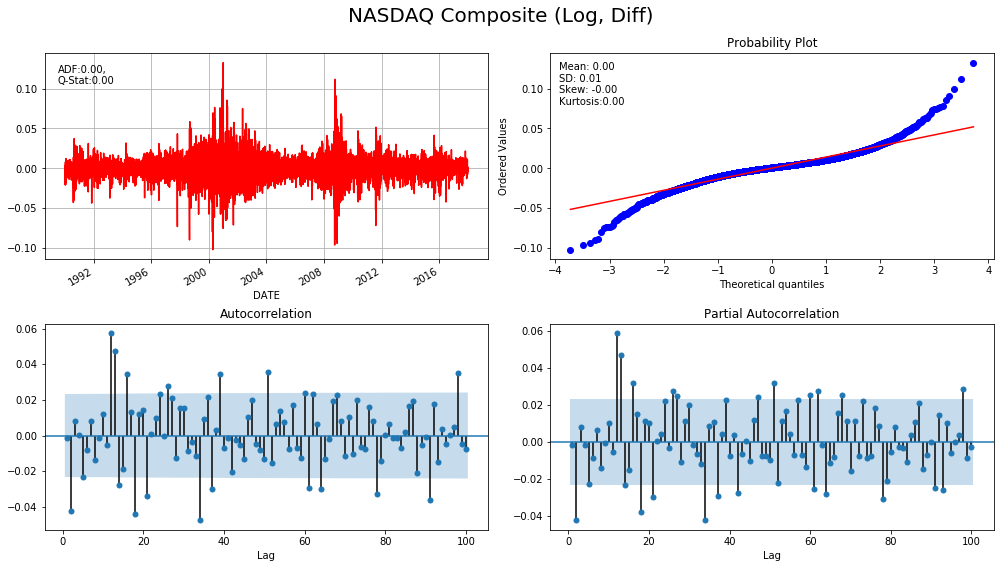

In [40]:
correlogram(log_nasdaq_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

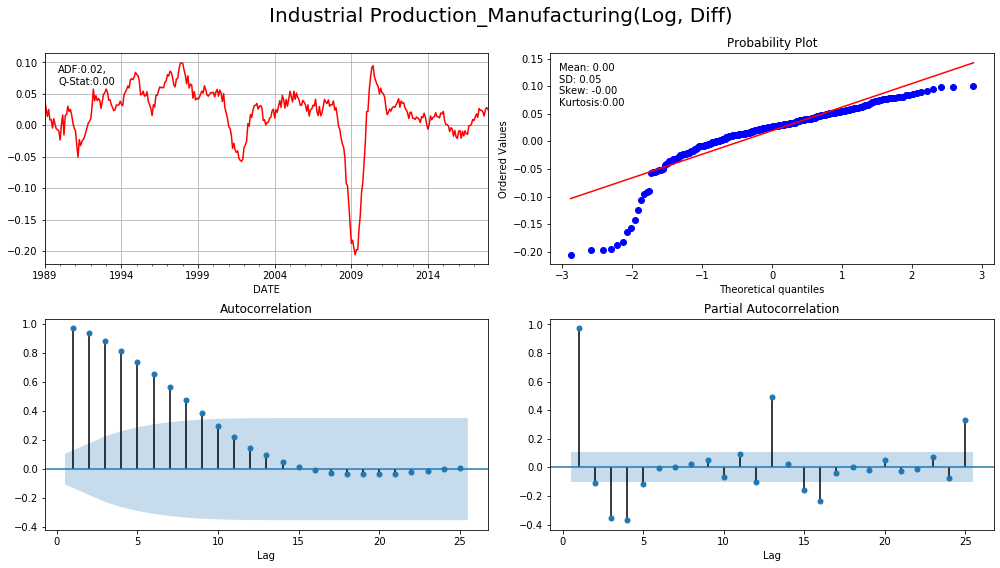

In [41]:
correlogram(log_industrial_production_diff, lags=25, title='Industrial Production_Manufacturing(Log, Diff)')

### Univariate Time Series Models

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time
series at the point in time of interest to a linear combination of lagged values of the series
and possibly past disturbance terms.

While exponential smoothing models are based on a description of the trend and seasonality in the data, **ARIMA models** aim to describe the autocorrelations in the data. 

**ARIMA(p, d, q)** models require stationarity and leverage two building blocks:
**Autoregressive (AR)** terms consisting of p-lagged values of the time series
**Moving average (MA)** terms that contain q-lagged disturbances


The **I stands for integrated** because the model can account for unit-root non-stationarity by differentiating the series d times. 

The term autoregression underlines that ARIMA models imply a regression of the time series on its own values

#### Invertability 

https://www.youtube.com/watch?v=BblqiDVn9P4

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [42]:
model1 = tsa.ARMA(endog=log_nasdaq_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=log_nasdaq, order=(2,1,2)).fit()

In [43]:
model1.params.sort_index()==model2.params.sort_index().values

ar.L1.NASDAQCOM    True
ar.L2.NASDAQCOM    True
const              True
ma.L1.NASDAQCOM    True
ma.L2.NASDAQCOM    True
dtype: bool

### Seasonal differencing vs SARIMAX

In [44]:
model1 = tsa.statespace.SARIMAX(log_industrial_production, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(log_industrial_production_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()


In [45]:
(model1.params.to_frame('SARIMAX').join(model2.params.to_frame('Seasonal_differencing')))

,SARIMAX,Seasonal_differencing
ar.L1,1.761977,1.765978
ar.L2,-0.784202,-0.788255
ma.L1,-0.841217,-0.859608
ma.L2,0.313356,0.353158
sigma2,0.000101,0.000101


### How to build ARIMA models 

In [46]:
log_industrial_production_diff

DATE
1989-01-01    0.039928
1989-02-01    0.026615
1989-03-01    0.014205
1989-04-01    0.025374
1989-05-01    0.008531
                ...   
2017-08-01    0.021458
2017-09-01    0.015012
2017-10-01    0.025884
2017-11-01    0.028315
2017-12-01    0.025158
Name: IPGMFN, Length: 348, dtype: float64

###  How to find the optimal lags 

In [47]:
log_industrial_production_diff.iloc[150:]

DATE
2001-07-01   -0.042827
2001-08-01   -0.040565
2001-09-01   -0.052077
2001-10-01   -0.055614
2001-11-01   -0.057136
                ...   
2017-08-01    0.021458
2017-09-01    0.015012
2017-10-01    0.025884
2017-11-01    0.028315
2017-12-01    0.025158
Name: IPGMFN, Length: 198, dtype: float64

In [48]:
len(log_industrial_production_diff)

348

We iterate over different (p, q) lag combinations and collect diagnostic statistics to compare the results of ARMA models.

However, we have two different variants in testing the dataset :

**Case 1)** pass a series of train dataset to predict the test data

**Case 2)** pass the whole train dataset **(Less computation power)**

#### Case 1

In [58]:
train_size = 120
test_results = {}
y_true = log_industrial_production_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(log_industrial_production_diff)):
            train_set = log_industrial_production_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        test_results[(p, q)] = [rmse,
                                np.mean(aic),
                                np.mean(bic),
                                convergence_error,
                                stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [59]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']

Models with low AIC and BIC values suggest that these models nicely straddle the requirements of goodness-of-fit and parsimony.

In [60]:
test_results.dropna()

RMSE         AIC         BIC  convergence  stationarity
p q                                                              
0 1   0.030183 -530.769444 -522.406969          0.0           0.0
  2   0.097291 -586.207104 -575.057137          0.0         102.0
  3   0.124803 -660.449815 -646.512356          0.0         182.0
  4   0.136629 -678.167783 -661.577317          0.0         206.0
1 0   0.011551 -727.389093 -719.026618          0.0           0.0
  1   0.029556 -732.051839 -720.901872          0.0          16.0
  2   0.021869 -743.997434 -730.059975          0.0          10.0
  3   0.018212 -747.753733 -731.028783          0.0           8.0
  4   0.018165 -753.080599 -733.568157          0.0           8.0
2 0  24.970287 -722.752973 -711.603006          0.0           0.0
  1   0.029587 -746.749992 -732.812533          3.0          17.0
  2   0.012664 -758.351998 -741.627048          0.0           4.0
  3   0.011705 -759.741501 -740.229059          0.0           3.0
  4   0.043274 -758.522420 -736.222486          0.0          24.0
3 0   0.010585 -747.347746 -733.410287          0.0           0.0
  1   0.011223 -754.332591 -737.607641          0.0           5.0
  2   0.011873 -757.461145 -737.948702          3.0           5.0
  3   0.010816 -759.110713 -736.810779          2.0          16.0
  4   0.043031 -762.634283 -737.546857          1.0          57.0
4 0   0.010008 -758.715127 -741.990177          0.0           0.0
  1   0.010033 -759.105330 -739.592888          0.0           2.0
  2   0.013710 -759.360198 -737.060264          0.0           4.0
  3   0.030602 -761.623866 -736.536440          2.0          41.0
  4   0.032571 -758.290446 -730.415529          1.0          60.0

In [61]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.3 KB


#### Case 2

In [53]:
train_size = 120 
y_true = log_industrial_production_diff[len(log_industrial_production_diff)-train_size:]
train_set = log_industrial_production_diff[:len(log_industrial_production_diff)-train_size]

In [54]:
test_results = {} #list for the results

for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        
        try:
            model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        y_pred, _, _ = model.forecast(steps=train_size)
        aic.append(model.aic)
        bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))       #calculate the mean square observations

        test_results[(p, q)] = [rmse,
                                aic,
                                bic,
                                convergence_error,
                                stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


KeyboardInterrupt: 

In [44]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']

In [45]:
test_results

RMSE                    AIC                    BIC convergence  \
p q                                                                        
0 1  0.0707259  [-1142.6168339195906]  [-1132.3287970327274]           0   
  2  0.0707654  [-1224.9254536736994]  [-1211.2080711578817]           0   
  3  0.0707384  [-1339.2430490213803]  [-1322.0963208766082]           0   
  4  0.0707384  [-1339.2430490213803]  [-1322.0963208766082]           0   
1 0  0.0697376  [-1430.7859870590114]  [-1420.4979501721482]           0   
  1  0.0698254  [-1433.8084551177599]  [-1420.0910726019422]           0   
  2  0.0699861  [-1446.1485567532495]  [-1429.0018286084774]           0   
  3  0.0699637  [-1452.6557989015473]  [-1432.0797251278207]           0   
  4  0.0700094  [-1450.8087511423287]  [-1426.8033317396475]           0   
2 0  0.0698767  [-1435.6862560957043]  [-1421.9688735798866]           0   
  1  0.0698847  [-1434.6154694888291]   [-1417.468741344057]           0   
  2  0.0700893    [-1450.86846058645]  [-1430.2923868127234]           0   
  3  0.0700356  [-1450.9384544907675]  [-1426.9330350880864]           0   
  4  0.0700261   [-1449.208945473736]  [-1421.7741804421005]           0   
3 0  0.0698774  [-1437.5051438356131]   [-1420.358415690841]           0   
  1   0.069926  [-1445.3258984936265]  [-1424.7498247198998]           0   
  2  0.0702322   [-1455.341776061402]   [-1431.336356658721]           0   
  3  0.0696861  [-1464.0109324785108]  [-1436.5761674468752]           0   
  4   0.069631   [-1462.329592723073]  [-1431.4654820624828]           0   
4 0  0.0699133  [-1453.5721924170853]  [-1432.9961186433586]           0   
  1  0.0699376  [-1451.7096239963998]  [-1427.7042045937187]           0   
  2  0.0699658  [-1449.8617832384139]  [-1422.4270182067783]           0   
  3  0.0698233   [-1462.981919843061]  [-1432.1178091824709]           0   
  4  0.0696383  [-1460.3414922923494]   [-1426.048036002805]           0   

    stationarity  
p q               
0 1            0  
  2            0  
  3            0  
  4            1  
1 0            0  
  1            0  
  2            0  
  3            0  
  4            0  
2 0            0  
  1            0  
  2            0  
  3            0  
  4            0  
3 0            0  
  1            0  
  2            0  
  3            0  
  4            0  
4 0            0  
  1            0  
  2            0  
  3            0  
  4            0

 Our objective is to minimize MSE,AIC and BIC

#####  Understand unstack 

http://www.datasciencemadesimple.com/reshape-using-stack-unstack-function-pandas-python/

In [98]:
#Create a multiple header dataframe

header = pd.MultiIndex.from_product([['Semester1','Semester2'],['Corporate_Finance','SAPM']])
d=([[12,45,67,56],[78,89,45,67],[45,67,89,90],[67,44,56,55]])
 
df = pd.DataFrame(d,
                  index=['X1','X2','X3','X4'],
                  columns=header)
stacked =df.stack(level=0)

stacked

Corporate_Finance  SAPM
X1 Semester1                 12    45
   Semester2                 67    56
X2 Semester1                 78    89
   Semester2                 45    67
X3 Semester1                 45    67
   Semester2                 89    90
X4 Semester1                 67    44
   Semester2                 56    55

In [99]:
stacked.unstack()

Corporate_Finance                SAPM          
           Semester1 Semester2 Semester1 Semester2
X1                12        67        45        56
X2                78        45        89        67
X3                45        89        67        90
X4                67        56        44        55

In [62]:
import seaborn as sns

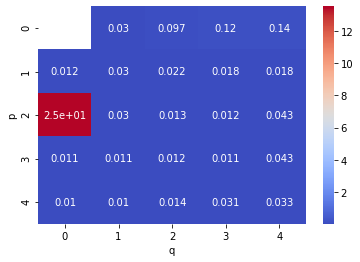

In [71]:
sns.heatmap(test_results.RMSE.unstack(), fmt='.2', annot=True,cmap='coolwarm',robust=True);

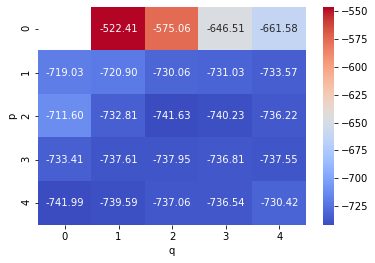

In [72]:
sns.heatmap(test_results.BIC.unstack(), fmt='.2f', annot=True,cmap='coolwarm',robust=True);

##  Best ARIMA model 

ARMA(4,0) and ARMA(2,2)

In [73]:
model = tsa.ARMA(endog=log_industrial_production_diff, order=(4,0)).fit(display=0)

In [74]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                     ARMA(4, 0)   Log Likelihood                1106.892
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 25 Jun 2020   AIC                          -2201.783
Time:                        13:48:22   BIC                          -2178.670
Sample:                    01-01-1989   HQIC                         -2192.581
                         - 12-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0205      0.009      2.222      0.026       0.002       0.039
ar.L1.IPGMFN     0.9252      0.051     18.260      0.000       0.826       1.025
ar.L2.IPGMFN     0.3341      0.071      4.70

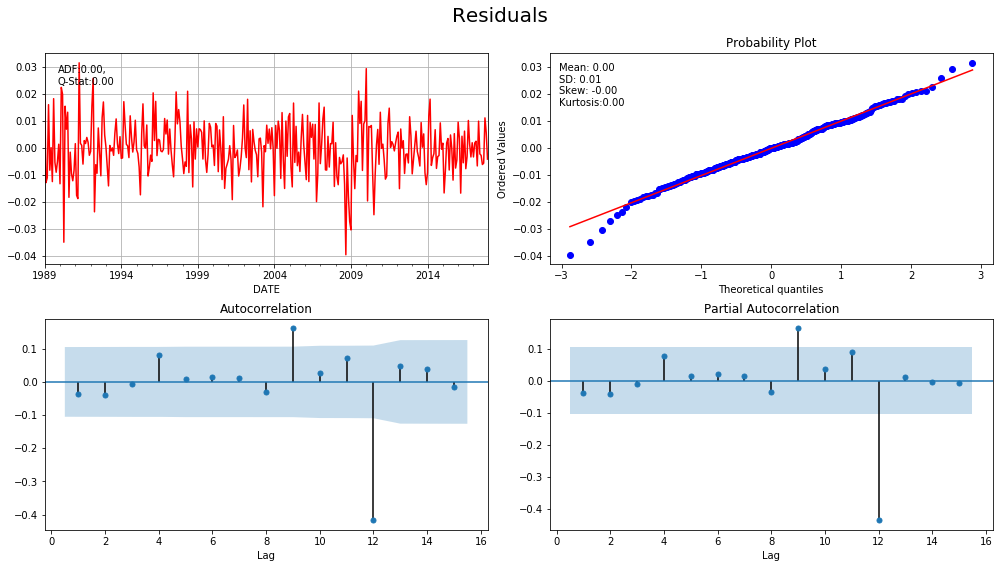

In [75]:
correlogram(model.resid,lags=15,title='Residuals')

### SARIMAX

In [77]:
model = tsa.SARIMAX(endog=log_industrial_production_diff.dropna(),
                    order=(4, 0, 0),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               IPGMFN   No. Observations:                  348
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                1129.603
Date:                              Thu, 25 Jun 2020   AIC                          -2245.206
Time:                                      13:48:55   BIC                          -2218.241
Sample:                                  01-01-1989   HQIC                         -2234.471
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7558      0.050     15.229      0.000       0.658       0.853
ar.L2          0.21

### Optimal number of lags in SARIMAX using Case 2 method 
**Less computation power required**

In [78]:
train_size = 120 
y_true = log_industrial_production_diff[len(log_industrial_production_diff)-train_size:]
train_set = log_industrial_production_diff[:len(log_industrial_production_diff)-train_size]
test_results = {}

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                try:
                    model = tsa.SARIMAX(endog=train_set,
                    order=(p1, 0, q1),
                    seasonal_order=(p2, 0, q2, 12)).fit()
                except LinAlgError:
                    convergence_error += 1
                except ValueError:
                    stationarity_error += 1

                preds = model.forecast(steps=train_size)
                aic=model.aic
                bic=model.bic
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(y_true, preds)
                test_results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  aic,
                                                  bic,
                                                  convergence_error,
                                                  stationarity_error]

0 1 0 0
0 1 0 1
0 1 0 2
0 1 1 0
0 1 1 1
0 1 1 2
0 1 2 0
0 1 2 1
0 1 2 2
0 2 0 0
0 2 0 1
0 2 0 2
0 2 1 0
0 2 1 1
0 2 1 2
0 2 2 0
0 2 2 1
0 2 2 2
0 3 0 0
0 3 0 1
0 3 0 2
0 3 1 0
0 3 1 1
0 3 1 2
0 3 2 0
0 3 2 1
0 3 2 2
1 0 0 0
1 0 0 1
1 0 0 2
1 0 1 0
1 0 1 1
1 0 1 2
1 0 2 0
1 0 2 1
1 0 2 2
1 1 0 0
1 1 0 1
1 1 0 2
1 1 1 0
1 1 1 1
1 1 1 2
1 1 2 0
1 1 2 1
1 1 2 2
1 2 0 0
1 2 0 1
1 2 0 2
1 2 1 0
1 2 1 1
1 2 1 2
1 2 2 0
1 2 2 1
1 2 2 2
1 3 0 0
1 3 0 1
1 3 0 2
1 3 1 0
1 3 1 1
1 3 1 2
1 3 2 0
1 3 2 1
1 3 2 2
2 0 0 0
2 0 0 1
2 0 0 2
2 0 1 0
2 0 1 1
2 0 1 2
2 0 2 0
2 0 2 1
2 0 2 2
2 1 0 0
2 1 0 1
2 1 0 2
2 1 1 0
2 1 1 1
2 1 1 2
2 1 2 0
2 1 2 1
2 1 2 2
2 2 0 0
2 2 0 1
2 2 0 2
2 2 1 0
2 2 1 1
2 2 1 2
2 2 2 0
2 2 2 1
2 2 2 2
2 3 0 0
2 3 0 1
2 3 0 2
2 3 1 0
2 3 1 1
2 3 1 2
2 3 2 0
2 3 2 1
2 3 2 2
3 0 0 0
3 0 0 1
3 0 0 2
3 0 1 0
3 0 1 1
3 0 1 2
3 0 2 0
3 0 2 1
3 0 2 2
3 1 0 0
3 1 0 1
3 1 0 2
3 1 1 0
3 1 1 1
3 1 1 2
3 1 2 0
3 1 2 1
3 1 2 2
3 2 0 0
3 2 0 1
3 2 0 2
3 2 1 0
3 2 1 1
3 2 1 2
3 2 2 0
3 2 2 1


In [80]:

sarimax_results = pd.DataFrame(test_results).T
sarimax_results.dropna()
sarimax_results.columns = ['RMSE', 'AIC', 'BIC','convergence', 'stationarity']
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, (0, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          135 non-null    float64
 1   AIC           135 non-null    float64
 2   BIC           135 non-null    float64
 3   convergence   135 non-null    float64
 4   stationarity  135 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [81]:
with pd.HDFStore('/Users/r.shyaamprasadh/Downloads/arima.h5') as store:
    store.put('arima_results/3', sarimax_results)

In [82]:
with pd.HDFStore('/Users/r.shyaamprasadh/Downloads/arima.h5') as store:
    df = store.get('arima_results/3')

In [83]:
df.sort_values('RMSE').head(10)

RMSE          AIC          BIC  convergence  stationarity
p1 q1 p2 q2                                                               
3  3  0  1   0.059131 -1460.391255 -1432.956490          0.0           0.0
   2  2  0   0.061204 -1460.165064 -1432.730299          0.0           0.0
0  3  0  0   0.061289 -1256.704168 -1242.986786          0.0           0.0
   2  0  0   0.061294 -1080.444547 -1070.156510          0.0           0.0
   1  0  0   0.061381 -1026.660348 -1019.801656          0.0           0.0
3  3  2  0   0.061750 -1479.608909 -1448.744798          0.0           0.0
1  3  0  1   0.061826 -1425.258646 -1404.682573          0.0           0.0
0  3  0  1   0.062041 -1269.129599 -1251.982871          0.0           0.0
   1  0  1   0.062044 -1055.535195 -1045.247158          0.0           0.0
   2  0  1   0.062288 -1107.811633 -1094.094250          0.0           0.0

In [89]:
print(df[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head())

                 RMSE          AIC          BIC
p1 q1 p2 q2                                    
3  3  0  1   0.059131 -1460.391255 -1432.956490
   2  2  0   0.061204 -1460.165064 -1432.730299
0  3  0  0   0.061289 -1256.704168 -1242.986786
   2  0  0   0.061294 -1080.444547 -1070.156510
   1  0  0   0.061381 -1026.660348 -1019.801656


In [136]:
df[(df.RMSE<df.RMSE.quantile(.05))&(df.BIC<df.BIC.quantile(0.01))]

,,,,RMSE,AIC,BIC,convergence,stationarity
p1,q1,p2,q2,,,,,


In [126]:
df[(df.BIC<df.BIC.quantile(.9))]

RMSE          AIC          BIC  convergence  stationarity
p1 q1 p2 q2                                                               
0  2  0  2   0.065195 -1175.922024 -1158.775296          0.0           0.0
      1  0   0.063573 -1157.373289 -1143.655907          0.0           0.0
         2   0.068502 -1181.210627 -1160.634553          0.0           0.0
      2  0   0.065206 -1181.605282 -1164.458554          0.0           0.0
   3  0  0   0.061289 -1256.704168 -1242.986786          0.0           0.0
...               ...          ...          ...          ...           ...
3  3  1  1   0.063661 -1507.843856 -1476.979746          0.0           0.0
         2   0.064594 -1513.043409 -1478.749952          0.0           0.0
      2  0   0.061750 -1479.608909 -1448.744798          0.0           0.0
         1   0.063094 -1500.406980 -1466.113523          0.0           0.0
         2   0.064900 -1454.450204 -1416.727402          0.0           0.0

[121 rows x 5 columns]

### Best_SARIMAX model

In [137]:
best_model = tsa.SARIMAX(endog=log_industrial_production_diff, order=(2, 0, 3),
                         seasonal_order=(1,0,0,12)).fit()
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 3)x(1, 0, [], 12)   Log Likelihood                1139.555
Date:                             Thu, 25 Jun 2020   AIC                          -2265.110
Time:                                     14:26:15   BIC                          -2238.144
Sample:                                 01-01-1989   HQIC                         -2254.374
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5046      0.108     13.955      0.000       1.293       1.716
ar.L2         -0.5271      

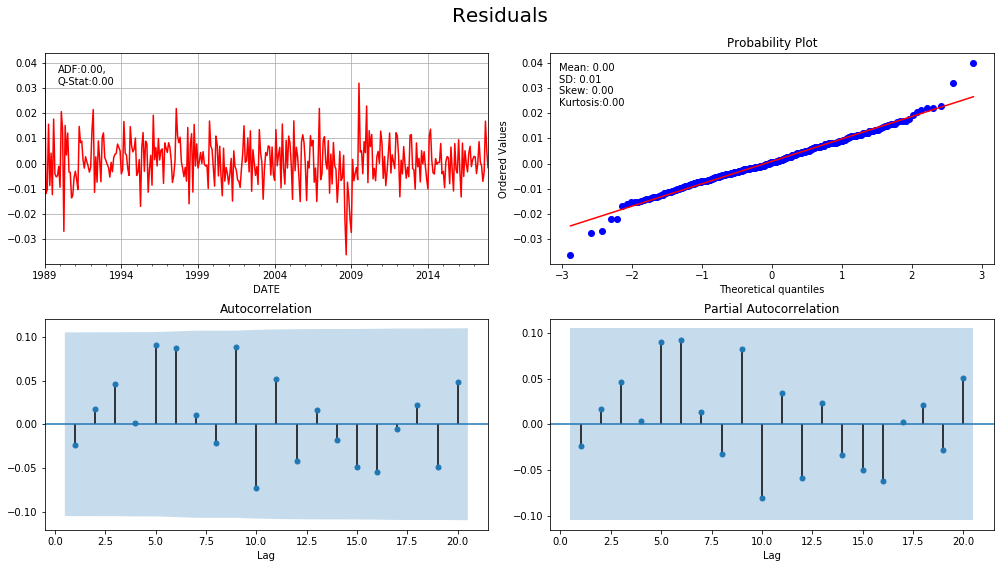

In [120]:
correlogram(best_model.resid, lags=20, title='Residuals')